In [2]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from lime import lime_image
from skimage.segmentation import mark_boundaries

# === Load model ===
model = tf.keras.models.load_model("pretrained_model/Resnet50_v3.keras")  # update path

c:\ProgramData\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
c:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [3]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from lime import lime_image
from skimage.segmentation import mark_boundaries


# === Settings ===
img_size = (224, 224)
base_dir = r"C:\Users\Anne\OneDrive - National University of Ireland, Galway\Documents\Data Analytics\PROJECT\Capstone2025_Anne\kaggle\working\merged_images"

# === Collect all image paths and labels ===
image_paths, labels = [], []
for label_folder in ["0", "1"]:  # 0 = Benign, 1 = Malignant
    folder = os.path.join(base_dir, label_folder)
    for fname in os.listdir(folder):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(folder, fname))
            labels.append(int(label_folder))


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 906ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 830ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461

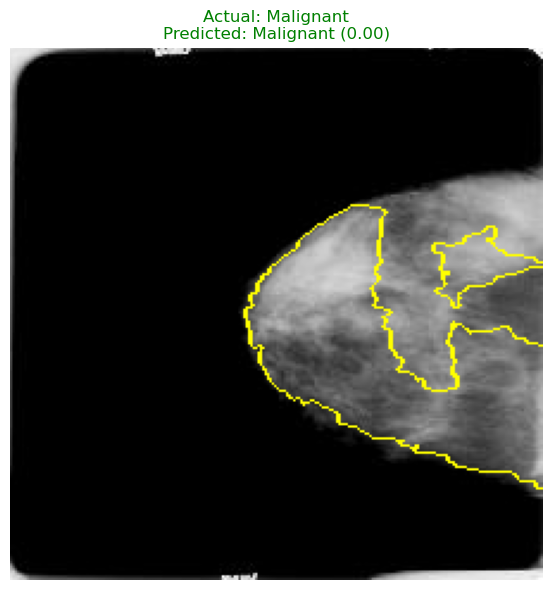

In [4]:
# === Randomly choose one image ===
idx = random.randint(0, len(image_paths) - 1)
img_path = image_paths[idx]
true_label = labels[idx]

# === Load image ===
img = image.load_img(img_path, target_size=img_size)
img_np = np.array(img).astype(np.uint8)


# === Define prediction function for LIME ===
def predict_fn(images):
    processed = []
    for im in images:
        im_resized = tf.image.resize(im, img_size)
        arr = tf.keras.applications.resnet50.preprocess_input(np.array(im_resized))
        processed.append(arr)
    processed = np.stack(processed, axis=0)
    preds = model.predict(processed)
    return np.hstack([(1 - preds), preds])  # For binary classification

# === Explain using LIME ===
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    img_np, 
    classifier_fn=predict_fn, 
    top_labels=2, 
    hide_color=0, 
    num_samples=1000
)

# === Get prediction ===
input_tensor = tf.keras.applications.resnet50.preprocess_input(np.expand_dims(img_np, axis=0).astype(np.float32))
pred_prob = model.predict(input_tensor, verbose=0)[0][0]
pred_class = 1 if pred_prob < 0.5 else 0  # Because 0 = Benign, 1 = Malignant

if pred_class not in explanation.local_exp:
    label_to_explain = explanation.top_labels[0]
else:
    label_to_explain = pred_class

temp, mask = explanation.get_image_and_mask(
    label=label_to_explain,
    positive_only=True,
    num_features=5,
    hide_rest=False
)
lime_image_overlay = mark_boundaries(temp / 255.0, mask)

actual = "Malignant" if true_label == 1 else "Benign"
predicted = "Malignant" if pred_class == 1 else "Benign"
confidence = f"{pred_prob:.2f}"
title_color = "green" if pred_class == true_label else "red"

# === Show plot ===
plt.figure(figsize=(6, 6))
plt.imshow(lime_image_overlay)
plt.title(f"Actual: {actual}\nPredicted: {predicted} ({confidence})", color=title_color)
plt.axis('off')
plt.tight_layout()
plt.show()


